<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Keypoint_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *$Keypoint Detection
        == with ==
 Transfer Learning$*


**Keypoint detection consists of locating key object parts. For example, the key parts of our faces include nose tips, eyebrows, eye corners, and so on. These parts help to represent the underlying object in a feature-rich manner. Keypoint detection has applications that include pose estimation, face detection, etc.**


**In this example, we will build a keypoint detector using the StanfordExtra dataset, using transfer learning. This example requires TensorFlow 2.4 or higher, as well as imgaug library, which can be installed using the following command:**

In [10]:
!pip install -q -U imgaug

#**Data collection**
The StanfordExtra dataset contains 12,000 images of dogs together with keypoints and segmentation maps. It is developed from the Stanford dogs dataset. It can be downloaded with the command below:

In [11]:
!wget -q http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar


Annotations are provided as a single JSON file in the StanfordExtra dataset and one needs to fill this form to get access to it. The authors explicitly instruct users not to share the JSON file, and this example respects this wish: you should obtain the JSON file yourself.


The JSON file is expected to be locally available as stanfordextra_v12.zip.


After the files are downloaded, we can extract the archives.

In [12]:
!tar xf images.tar

# **Download "standfordextra.zip" Fill this form = https://forms.gle/sRtbicgxsWvRtRmUA**

In [ ]:
# !unzip -qq ~/stanfordextra_v12.zip

In [13]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

In [14]:
img_size = 224
batch_size = 16
epoch = 5
num_keypoints = 24 * 2

# **Load data**
The authors also provide a metadata file that specifies additional information about the keypoints, like color information, animal pose name, etc. We will load this file in a pandas dataframe to extract information for visualization purposes.

In [15]:
IMG_DIR = "Images"
JSON = "/content/StanfordExtra_v12.json"
KEYPOINT_DEF = "https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"


with open(JSON) as infile:
  json_data = json.load(infile)


json_dict = {i["img_path"]: i for i in json_data}

In [16]:
json_dict

{'n02085782-Japanese_spaniel/n02085782_2886.jpg': {'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg',
  'img_width': 350,
  'img_height': 272,
  'img_bbox': [205, 20, 116, 201],
  'is_multiple_dogs': False,
  'joints': [[108.66666666666667, 252.0, 1],
   [147.66666666666666, 229.0, 1],
   [163.5, 208.5, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [54.0, 244.0, 1],
   [77.33333333333333, 225.33333333333334, 1],
   [79.0, 196.5, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [150.66666666666666, 86.66666666666667, 1],
   [88.66666666666667, 73.0, 1],
   [116.0, 106.33333333333333, 1],
   [109.0, 123.33333333333333, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0]],
  'seg': 'Yi71c01S74jHNU75gHMX75eHM[74cHM\\76`HL4HQ7k0lHXOT7R1O2N010O010jLiNROW1m0lNROT1m0oNPOQ1P1QOoNn0R1ROnNn0oMkNQ2:Nl0oMlNQ2:0j0nMnNP291j0mMoNR280j0kMPOLEg1c0`0i0lMCb1Db0i0jMGa1Ae0h0iMI`1_Og0j0fMK`1\\Oj0i0eMN^1ZOl0i0dM1]1WOm0k0cM2]1TOP1j0bM4


In this example, the keys we are interested in are:

img_path

joints

There are a total of 24 entries present inside joints. Each entry has 3 values:


x-coordinate

y-coordinate

visibility flag of the keypoints (1 indicates visibility and 0 indicates non-visibility

As we can see joints contain multiple [0, 0, 0] entries which denote that those keypoints were not labeled. In this example, we will consider both non-visible as well as unlabeled keypoints in order to allow mini-batch learning.

In [17]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

# Extract the colours and labels.
colours = keypoint_def["Hex colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()

# Utility for reading an image and for getting its annotations.
def get_dog(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

# **Visualize data**

Now, we write a utility function to visualize the images and their keypoints.

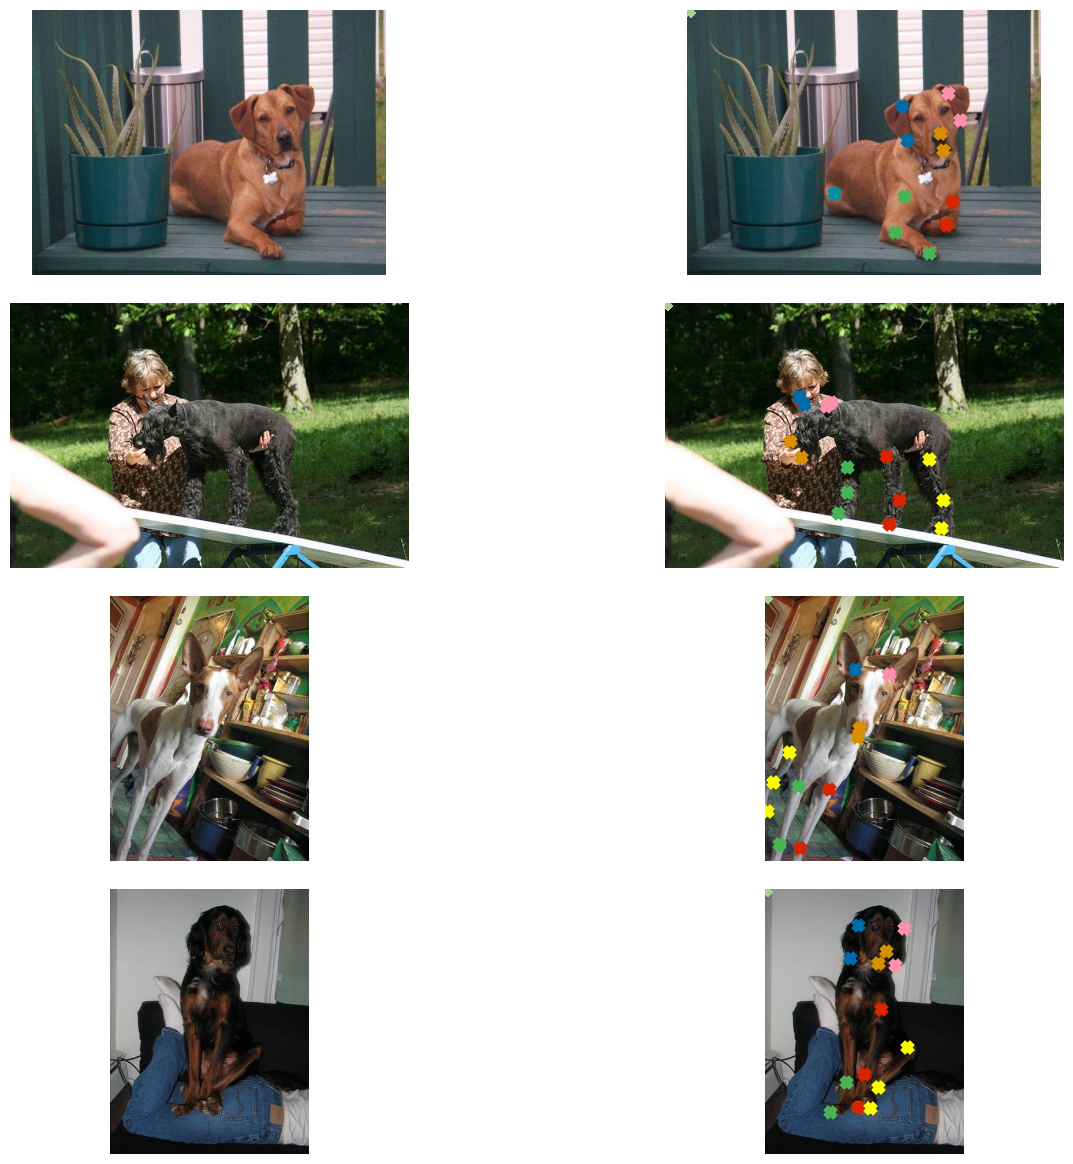

In [18]:
# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_dog(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

The plots show that we have images of non-uniform sizes, which is expected in most real-world scenarios. However, if we resize these images to have a uniform shape (for instance (224 x 224)) their ground-truth annotations will also be affected. The same applies if we apply any geometric transformation (horizontal flip, for e.g.) to an image. Fortunately, imgaug provides utilities that can handle this issue. In the next section, we will write a data generator inheriting the [keras.utils.Sequence](/api/utils/python_utils#sequence-class) class that applies data augmentation on batches of data using imgaug.

In [19]:
json_dict["n02088094-Afghan_hound/n02088094_5150.jpg"]

{'img_path': 'n02088094-Afghan_hound/n02088094_5150.jpg',
 'img_width': 333,
 'img_height': 500,
 'joints': [[91.0, 478.6666666666667, 1.0],
  [147.5, 437.5, 1.0],
  [263.3333333333333, 326.0, 1.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [31.0, 454.0, 1.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [224.0, 111.2, 1.0],
  [166.0, 105.0, 1.0],
  [121.8, 177.2, 1.0],
  [148.8, 194.4, 1.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 'img_bbox': [1, 70, 330, 428],
 'is_multiple_dogs': False,
 'seg': 'Un0`0a>c0N2O1O010O00000000000001O01O000O2O001O001O010O1O1O100O1O100O1O1O100O1O2N100O1O1O2N1O100O2N1O1O1O2N100O1O2N1N2N2N3N1N2N2N2N3N4K4M4L3L2O2M3M2O2J5N3N1N3M3N1N3N1O2M2O101O2N0O2O0O1O10000100O001O0000000000002O1N1O1O001O1O000O100000TJSL1m3MWL1i3MZL1h3LZL4f3K[L5e3J]L5c3J^L6b3I`L6`3IaL6`3IbL6^3IdL6\\3IeL7[3HgL6Z3

# **Prepare data generator**

In [20]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size= batch_size , train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, img_size, img_size, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, num_keypoints), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 24 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / img_size

        return (batch_images, batch_keypoints)

# **Define augmentation transforms**

In [21]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(img_size, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(img_size, interpolation="linear")])

# **Create training and validation splits**

In [22]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)])

In [23]:
len(train_keys), len(validation_keys)

(10658, 1880)

# **Data generator investigation**

Total batches in training set: 666
Total batches in validation set: 117


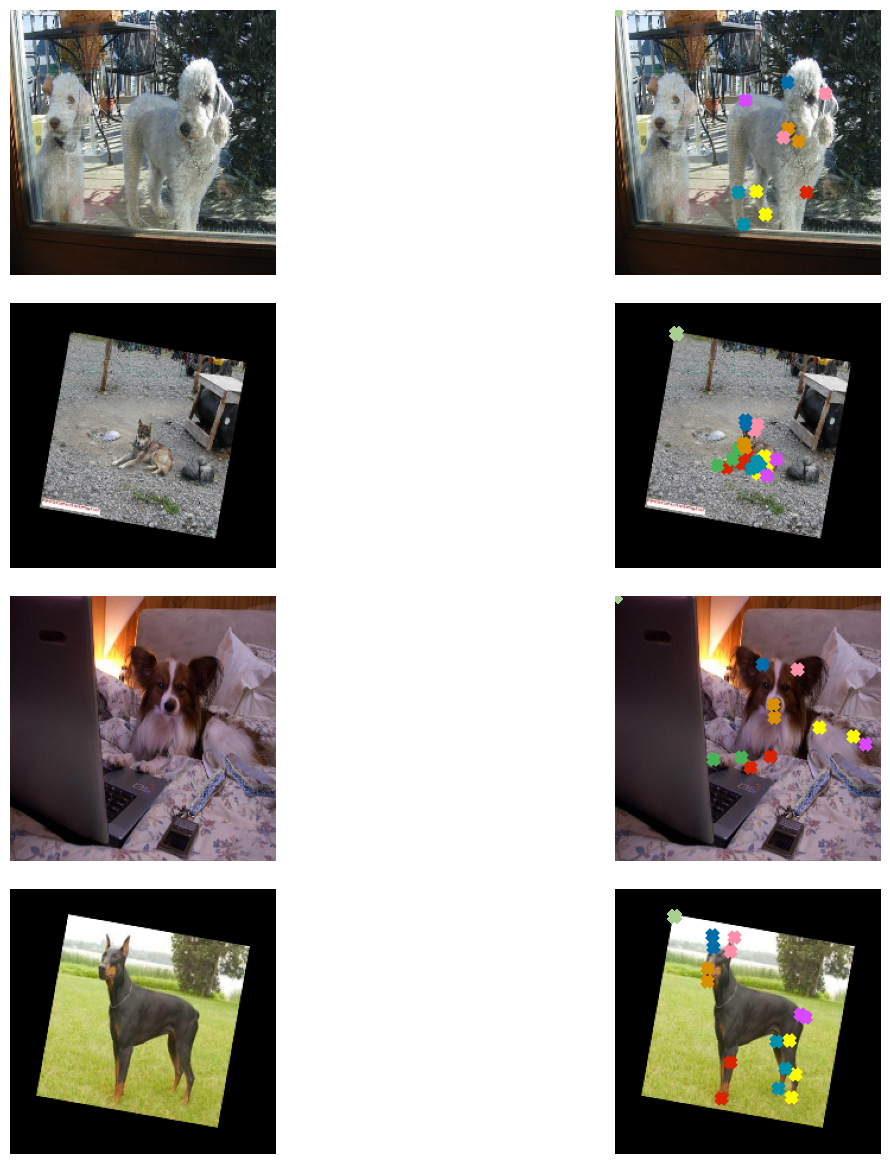

In [24]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train = False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 24, 2) * img_size
visualize_keypoints(sample_images[:4], sample_keypoints)

# **Model building**


The Stanford dogs dataset (on which the StanfordExtra dataset is based) was built using the ImageNet-1k dataset. So, it is likely that the models pretrained on the ImageNet-1k dataset would be useful for this task. We will use a MobileNetV2 pre-trained on this dataset as a backbone to extract meaningful features from the images and then pass those to a custom regression head for predicting coordinates.

In [25]:
def get_model():
  backbone = keras.applications.MobileNetV2(weights = "imagenet", include_top = False, input_shape = (img_size, img_size, 3))
  backbone.trainable = False

  inputs = layers.Input((img_size, img_size, 3))
  x = keras.applications.mobilenet_v2.preprocess_input(inputs)
  x = backbone(x)
  x = layers.Dropout(0.3)(x)
  x = layers.SeparableConv2D(num_keypoints, kernel_size = 5, strides = 1, activation = "relu")(x)
  outputs = layers.SeparableConv2D(num_keypoints,  kernel_size = 3, strides = 1, activation = "sigmoid")(x)
  return keras.Model(inputs, outputs,  name = "keypoint_detector")

Our custom network is fully-convolutional which makes it more parameter-friendly than the same version of the network having fully-connected dense layers.

In [26]:
get_model().summary()

Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                 

Notice the output shape of the network: (None, 1, 1, 48). This is why we have reshaped the coordinates as: batch_keypoints[i, :] = np.array(kp_temp).reshape(1, 1, 24 * 2).

In [27]:
model = get_model()
model.compile(optimizer = keras.optimizers.Adam(1e-4), loss = "mse")

In [ ]:
model.fit(train_dataset, validation_data = validation_dataset, epochs = epoch)

Epoch 1/5
666/666 [==============================] - 127s 163ms/step - loss: 0.0870 - val_loss: 0.0774
Epoch 2/5
258/666 [==========>...................] - ETA: 1:26 - loss: 0.0765

In [ ]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 24, 2) * img_size
predictions = model.predict(sample_val_images).reshape(-1, 24, 2) * img_size

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)